In [2]:
import sys
sys.path.insert(1, '../scripts/')

import os
import csv
import requests
import nbm_funcs
import matplotlib

import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp

import seaborn as sns
import scipy.stats as scipy
import urllib.request as req
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

os.environ["OMP_NUM_THREADS"] = "1"

***
***
# Configuration
Select 'site' to evaluate, modify 'vsite' if an alternate verification site is preferred<br>
Fixed 'date0' at the start of the NBM v3.2 period (2/20/2020)<br>
Full lead time is 263 hours - Note if date1 is within this period, there will be missing verification data as it does not exist yet!

In [3]:
# NBM 1D Viewer Site to use
site = nbm_funcs._site = 'KSEA'

# Data Range
lead_time_end = 180
init_hours = nbm_funcs._init_hours = [13]#[1, 7, 13, 19]

date0 = nbm_funcs._date0 = datetime(2020, 3, 1)#3, 1)
date1 = nbm_funcs._date1 = datetime(2020, 9, 15)#today

In [4]:
# datadir = nbm_funcs._datadir = '../archive/%s/data/'%site
datadir = nbm_funcs._datadir = '../archive/data/'
os.makedirs(datadir, exist_ok=True)

dates = nbm_funcs._dates = pd.date_range(date0, date1, freq='1D')
date2 = nbm_funcs._date2 = date1 + timedelta(hours=lead_time_end)

print(('\nForecast Site: {}\nInit Hours: '+
      '{}\nFirst Init: {}\nLast Init: {}\nLast Verif: {}').format(
    site, init_hours, date0, date1, date2))


Forecast Site: KSEA
Init Hours: [13]
First Init: 2020-03-01 00:00:00
Last Init: 2020-09-15 00:00:00
Last Verif: 2020-09-22 12:00:00


***
***
# Obtain observation data from SynopticLabs (MesoWest) API
These are quality-controlled precipitation observations with adjustable accumulation periods<br>
See more at: https://developers.synopticdata.com/mesonet/v2/stations/precipitation/
<br><br>
If no observation file exists, will download and save for future use

In [5]:
# Get metadata for the select point
meta_base = 'https://api.synopticdata.com/v2/stations/metadata?'
api_token = '&token=a2386b75ecbc4c2784db1270695dde73'
meta_site = '&stid=%s&complete=1'%site
url = meta_base + api_token + meta_site
# print(url)

site_meta_raw = requests.get(url).json()
# print(meta_raw['STATION'][0])

zone = site_meta_raw['STATION'][0]['NWSZONE']
cwa = site_meta_raw['STATION'][0]['CWA']

print('Site: %s\nCWA: %s\nZone: %s'%(site, cwa, zone))

Site: KSEA
CWA: SEW
Zone: WA558


In [6]:
# Get a list of sites in the CWA that report precip
precip_base = 'https://api.synopticdata.com/v2/stations/precip?&complete=1&interval=6'
zone_query = '&nwszone=%s'%zone
cwa_query = '&cwa=%s'%cwa
date_query = '&start=%s&end=%s'%(
    date0.strftime('%Y%m%d%H%M'),
    (date0+timedelta(hours=6)).strftime('%Y%m%d%H%M'))

# We could query for a list of relevant zones within a CWA here
# Then pass a list of zones to the zone query
# !Add later!

# Fix this later! Temp fix to expand the zone for more NWS/FAA/RAWS stations
# Due to 1D Viewer file limitation - Ask Chad for advice?
zone_query = cwa_query

url = precip_base + api_token + zone_query + date_query
zone_meta_raw = requests.get(url).json()

meta = []
for station in zone_meta_raw['STATION']:
    
#     We need to get back to a zone query - for now this will work with a CWA query to only hit sites that exist within a CWA    
    if (('NWS' in station['SHORTNAME']) | ('RAWS' in station['SHORTNAME']) & (station['STID'][0] == 'K')):
        meta.append({k:station[k] for k in station.keys() if type(station[k]) == str})
        
meta = pd.DataFrame(meta).set_index('STID')

meta.shape

(24, 19)

In [7]:
for k in meta:
    try:
        meta[k] = meta[k].astype(float)
    except:
        pass

meta

,NWSFIREZONE,ELEV_DEM,TIMEZONE,SGID,SHORTNAME,ELEVATION,GACC,STATUS,LONGITUDE,COUNTY,STATE,CWA,NWSZONE,ID,MNET_ID,NAME,COUNTRY,LATITUDE,WIMS_ID
STID,,,,,,,,,,,,,,,,,,,
KAWO,SEW656,124.7,America/Los_Angeles,NW01,NWS/FAA,125.0,NWCC,ACTIVE,-122.159090,Snohomish,WA,SEW,WA507,97.0,1.0,Arlington Municipal Airport,US,48.158500,NaN
KBFI,SEW654,9.8,America/Los_Angeles,NW01,NWS/FAA,20.0,NWCC,ACTIVE,-122.314700,King,WA,SEW,WA558,102.0,1.0,Boeing Field - King County International Airport,US,47.545480,NaN
KBLI,SEW653,147.6,America/Los_Angeles,NW01,NWS/FAA,148.0,NWCC,ACTIVE,-122.540640,Whatcom,WA,SEW,WA503,111.0,1.0,"Bellingham, Bellingham International Airport",US,48.799110,NaN
KCLM,SEW653,259.2,America/Los_Angeles,NW01,NWS/FAA,262.0,NWCC,ACTIVE,-123.506610,Clallam,WA,SEW,WA514,133.0,1.0,Port Angeles Fairchild International Airport,US,48.121940,NaN
KFHR,SEW653,108.3,America/Los_Angeles,NW01,NWS/FAA,112.0,NWCC,ACTIVE,-123.026370,San Juan,WA,SEW,WA001,188.0,1.0,Friday Harbor Airport,US,48.520000,NaN
KGRF,SEW654,288.7,America/Los_Angeles,NW01,NWS/FAA,302.0,NWCC,ACTIVE,-122.550000,Pierce,WA,SEW,WA509,204.0,1.0,Fort Lewis / Gray U. S. Army Airfield,US,47.116670,NaN
KHQM,SEW649,0.0,America/Los_Angeles,NW01,NWS/FAA,13.0,NWCC,ACTIVE,-123.920000,Grays Harbor,WA,SEW,WA517,220.0,1.0,"Hoquiam, Bowerman Airport",US,46.971110,NaN
KNUW,SEW653,39.4,America/Los_Angeles,NW01,NWS/FAA,43.0,NWCC,ACTIVE,-122.663520,Island,WA,SEW,WA510,299.0,1.0,Whidbey Island Naval Air Station - Ault Field,US,48.355250,NaN
KOLM,SEW655,187.0,America/Los_Angeles,NW01,NWS/FAA,203.0,NWCC,ACTIVE,-122.903330,Thurston,WA,SEW,WA504,309.0,1.0,"Olympia, Olympia Airport",US,46.973330,NaN


<hr><hr>

## Plot a map of the stations, color by elevation, marker by network

In [8]:
import geopandas as gpd
from glob import glob

geodir = '../forecast-zones/'
zones_shapefile = glob(geodir + '*.shp')[0]

# Read the shapefile
zones = gpd.read_file(zones_shapefile)
# Prune to Western Region using TZ
zones = zones.set_index('TIME_ZONE').loc[['M', 'Mm', 'm', 'MP', 'P']].reset_index()
zones = zones[zones['CWA'] == cwa]

# zones.to_file(geodir + 'forecast-zones.json', driver = 'GeoJSON')
zones

,TIME_ZONE,STATE,CWA,FE_AREA,ZONE,NAME,STATE_ZONE,LON,LAT,SHORTNAME,InPoly_FID,SimPgnFlag,MaxSimpTol,MinSimpTol,geometry
622,P,WA,SEW,nw,001,San Juan County,WA001,-122.9627,48.5786,San Juan County,3444,0,0.0001,0.0001,"MULTIPOLYGON (((-122.81197 48.41291, -122.8125..."
623,P,WA,SEW,nw,514,Eastern Strait of Juan de Fuca,WA514,-123.2615,48.0760,Eastern Strait of Juan de Fuca,3445,0,0.0001,0.0001,"MULTIPOLYGON (((-122.92453 48.06274, -122.9242..."
624,P,WA,SEW,nw,506,Western Skagit County,WA506,-122.3668,48.4646,Western Skagit County,3446,0,0.0001,0.0001,"MULTIPOLYGON (((-122.37564 48.29217, -122.3772..."
625,P,WA,SEW,wc,568,West Slopes North Central Cascades and Passes,WA568,-121.4861,47.8035,West Slopes North Central Cascd,3447,0,0.0001,0.0001,"POLYGON ((-121.58156 48.29923, -121.57692 48.2..."
626,P,WA,SEW,wc,555,East Puget Sound Lowlands,WA555,-122.0086,47.5465,East Puget Sound Lowlands,3448,0,0.0001,0.0001,"POLYGON ((-122.12630 48.29801, -122.11340 48.2..."
627,P,WA,SEW,wc,567,West Slopes North Cascades and Passes,WA567,-121.5187,48.6678,West Slopes North Cascades,3449,0,0.0001,0.0001,"POLYGON ((-121.94080 48.99981, -121.92020 48.9..."
628,P,WA,SEW,nw,513,Olympics,WA513,-123.5990,47.7525,Olympics,3450,0,0.0001,0.0001,"POLYGON ((-123.92160 48.11601, -123.86739 48.1..."
629,P,WA,SEW,wc,512,Lower Chehalis Valley Area,WA512,-123.5111,47.0579,Lower Chehalis Valley Area,3451,0,0.0001,0.0001,"POLYGON ((-123.77270 47.35121, -123.74870 47.3..."
630,P,WA,SEW,nw,516,North Coast,WA516,-124.4067,47.9309,North Coast,3452,0,0.0001,0.0001,"MULTIPOLYGON (((-124.48966 47.67362, -124.4907..."
631,P,WA,SEW,nw,503,Western Whatcom County,WA503,-122.4772,48.8588,Western Whatcom County,3453,0,0.0001,0.0001,"MULTIPOLYGON (((-122.50343 48.65564, -122.5041..."


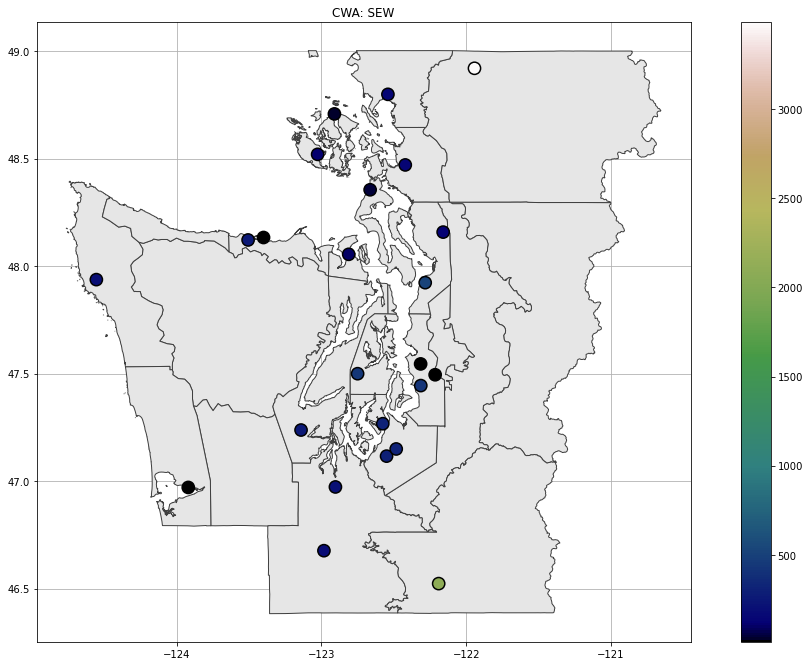

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(16, 16), facecolor='w')
ax.set_title('CWA: %s'%cwa)

zones.plot(column='NAME', color='0.9', edgecolor='0.25', ax=ax, zorder=10)

cbd = ax.scatter(meta['LONGITUDE'], meta['LATITUDE'], c=meta['ELEVATION'], cmap='gist_earth', 
                 s=150, marker='o', edgecolor='k', linewidth=1.5, zorder=20,)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5)
plt.colorbar(cbd, cax=cax)
ax.grid(True, zorder=-10)

# ax.set_ylim(bottom=46.30, top=49.10)
# ax.set_xlim(left=-124.9, right=-120.6)

fig.show()

<hr><hr>

In [10]:
# Single-process
ob_files = [nbm_funcs.get_precip_obs_mp(i) for i in meta.index.values]
ob_files = [f for f in ob_files if f is not None]

# Multi-process (needs fixing...)
# with mp.get_context('fork').Pool(mp.cpu_count()) as p:    
#     ob_files = p.map_async(nbm_funcs.get_precip_obs_mp, meta.index.values, chunksize=1)
#     ob_files.wait()
# ob_files = [f for f in ob_files.get() if f is not None]

obs = []
for file in ob_files:
    site = file.split('/')[-1].split('_')[0]
    iobs = pd.read_pickle(file)
    iobs['Site'] = np.full(iobs.index.size, fill_value=site, dtype='U10')
    iobs = iobs.reset_index().set_index(['ValidTime', 'Site'])
    obs.append(iobs)
    
obs = pd.concat(obs).sort_index()

mm_in = 1/25.4
obs *= mm_in
[obs.rename(columns={k:k.replace('mm', 'in')}, inplace=True) for k in obs.keys()]

# OPTIONAL! Drop NaN rows... may help elim lower qual dataw
# obs = obs.dropna(how='all')

sites = np.unique(obs.index.get_level_values(1))
print(sites)

print(obs.shape)
obs.head(10)

['K0S9' 'KAWO' 'KBFI' 'KBLI' 'KBVS' 'KCFW1' 'KCLM' 'KCLS' 'KFHR' 'KGRF'
 'KHQM' 'KNOW' 'KNUW' 'KOLM' 'KORS' 'KOSW1' 'KPAE' 'KPWT' 'KRNT' 'KSEA'
 'KSHN' 'KTCM' 'KTIW' 'KUIL']
(19656, 3)


6h_precip_in  12h_precip_in  24h_precip_in
ValidTime  Site                                             
2020-03-02 K0S9           0.00           0.00           0.00
           KAWO           0.01           0.01           0.01
           KBFI           0.00           0.00           0.09
           KBLI           0.00           0.00           0.00
           KBVS           0.01           0.02           0.02
           KCFW1          0.06           0.06           0.13
           KCLM           0.00           0.00           0.00
           KCLS           0.00           0.00           0.00
           KFHR           0.00           0.00           0.00
           KGRF           0.00           0.00           0.00

In [11]:
obs.describe().T

,count,mean,std,min,25%,50%,75%,max
6h_precip_in,19582.0,0.013478,0.054444,0.0,0.0,0.0,0.000000,1.020000
12h_precip_in,19563.0,0.026945,0.089107,0.0,0.0,0.0,0.000984,1.540000
24h_precip_in,19601.0,0.053839,0.140836,0.0,0.0,0.0,0.030000,2.372047


***
***
# Obtain NBM forecast data from NBM 1D Viewer (csv file API)
These are the NBM 1D output files extracted from the viewer with 3 set accumulation periods<br>
See more at: https://hwp-viz.gsd.esrl.noaa.gov/wave1d/?location=KSLC&col=2&hgt=1&obs=true&fontsize=1&selectedgroup=Default
<br><br>
If no forecast file exists, will download and save for future use. This can take some time.

In [12]:
# nbm_files = [nbm_funcs.get_nbm_1d_mp(i) for i in meta.index]
# nbm_files = [f for f in nbm_files if f is not None]

with mp.get_context('fork').Pool(mp.cpu_count()) as p:    
    nbm_files = p.map_async(nbm_funcs.get_nbm_1d_mp, meta.index, chunksize=1)
    nbm_files.wait()  
nbm_files = [f for f in nbm_files.get() if f is not None]

nbm = []
for file in nbm_files:
    site = file.split('/')[-1].split('_')[0]
    inbm = pd.read_pickle(file)
    inbm['Site'] = np.full(inbm.index.size, fill_value=site, dtype='U10')
    inbm = inbm.reset_index().set_index(['InitTime', 'ValidTime', 'Site'])
    nbm.append(inbm)
    
nbm = pd.concat(nbm).sort_index()
nbm

# Convert mm to in
for k in nbm.keys():
    if 'prob' not in k:
        nbm[k] *= mm_in

lead = [row[1]-row[0] for row in nbm.index]
lead = np.array([1 + row.days*24 + (row.seconds/3600) for row in lead], dtype=int)
nbm.insert(0, 'LeadTime', lead)

# Nix values where lead time shorter than acc interval
for k in [k for k in nbm.keys() if k != 'LeadTime']:
    if 'APCP24hr' in k:
        nbm[k][nbm['LeadTime'] < 24] = np.nan
    elif 'APCP12hr' in k:
        nbm[k][nbm['LeadTime'] < 12] = np.nan
    elif 'APCP6r' in k:
        nbm[k][nbm['LeadTime'] < 6] = np.nan
    else:
        pass
    
nbm = nbm.dropna(subset=[k for k in nbm.keys() if k != 'LeadTime'], how='all')
nbm[25:50]

LeadTime  APCP12hr_surface  \
InitTime            ValidTime           Site                               
2020-03-02 13:00:00 2020-03-03 00:00:00 KBLI        12          0.148307   
                                        KBVS        12          0.159803   
                                        KCLM        12          0.037677   
                                        KCLS        12          0.058150   
                                        KFHR        12          0.066299   
                                        KGRF        12          0.053346   
                                        KHQM        12          0.071260   
                                        KNOW        12          0.016929   
                                        KNUW        12          0.100000   
                                        KOLM        12          0.041063   
                                        KORS        12          0.086181   
                                        KPAE        12          0.110787   
                                        KPWT        12          0.097913   
                                        KRNT        12          0.094449   
                                        KSEA        12          0.063543   
                                        KSHN        12          0.074685   
                                        KTCM        12          0.061732   
                                        KTIW        12          0.045354   
                                        KUIL        12          0.192047   
                    2020-03-03 06:00:00 K0S9        18          0.114055   
                                        KAWO        18          0.390748   
                                        KBFI        18          0.100276   
                                        KBLI        18          0.273307   
                                        KBVS        18          0.331890   
                                        KCLM        18          0.089803   

                                              APCP12hr_surface_1% level  \
InitTime            ValidTime           Site                              
2020-03-02 13:00:00 2020-03-03 00:00:00 KBLI                   0.000079   
                                        KBVS                   0.000079   
                                        KCLM                   0.000000   
                                        KCLS                   0.000000   
                                        KFHR                   0.000000   
                                        KGRF                   0.000000   
                                        KHQM                   0.000000   
                                        KNOW                   0.000000   
                                        KNUW                   0.000000   
                                        KOLM                   0.000000   
                                        KORS                   0.000000   
                                        KPAE                   0.000000   
                                        KPWT                   0.000000   
                                        KRNT                   0.000000   
                                        KSEA                   0.000000   
                                        KSHN                   0.000000   
                                        KTCM                   0.000000   
                                        KTIW                   0.000000   
                                        KUIL                   0.000000   
                    2020-03-03 06:00:00 K0S9                   0.000000   
                                        KAWO                   0.000000   
                                        KBFI                   0.000000   
                                        KBLI                   0.002677   
                                        KBVS                   0.001063   
                                        KCL

In [13]:
# Display some basic stats
nbm.loc[:, ['APCP6hr_surface', 'APCP6hr_surface_70% level', 'APCP6hr_surface_50% level',
            'APCP12hr_surface', 'APCP12hr_surface_70% level', 'APCP12hr_surface_50% level',
            'APCP24hr_surface', 'APCP24hr_surface_70% level', 'APCP24hr_surface_50% level',
            'APCP24hr_surface_prob >0.254',
            ]].describe().T

,count,mean,std,min,25%,50%,75%,max
APCP6hr_surface,189230.0,0.015274,0.044235,0.0,0.0,0.000,0.000000,0.657913
APCP6hr_surface_70% level,193248.0,0.012919,0.038606,0.0,0.0,0.000,0.001299,0.610118
APCP6hr_surface_50% level,193248.0,0.004257,0.021122,0.0,0.0,0.000,0.000000,0.519252
APCP12hr_surface,188856.0,0.039433,0.093619,0.0,0.0,0.000,0.020079,1.143819
APCP12hr_surface_70% level,188856.0,0.031001,0.072313,0.0,0.0,0.000,0.022047,1.163425
APCP12hr_surface_50% level,188856.0,0.011871,0.042111,0.0,0.0,0.000,0.000000,0.995197
APCP24hr_surface,105408.0,0.077772,0.158426,0.0,0.0,0.000,0.076732,1.953543
APCP24hr_surface_70% level,105408.0,0.074230,0.132339,0.0,0.0,0.005,0.093858,1.403583
APCP24hr_surface_50% level,105408.0,0.035121,0.085469,0.0,0.0,0.000,0.018583,1.207087
APCP24hr_surface_prob >0.254,105408.0,32.496670,28.621890,0.0,8.0,25.000,52.000000,100.000000


#### Plot the distribution of precipitation observations vs forecasts for assessment of representativeness

In [14]:
# Label fix:
site = nbm_funcs._site = zone_query.replace('&', '').replace('=', '_').upper()

figdir = nbm_funcs._figdir = '../archive//%s/figures/'%site
os.makedirs(figdir, exist_ok=True)

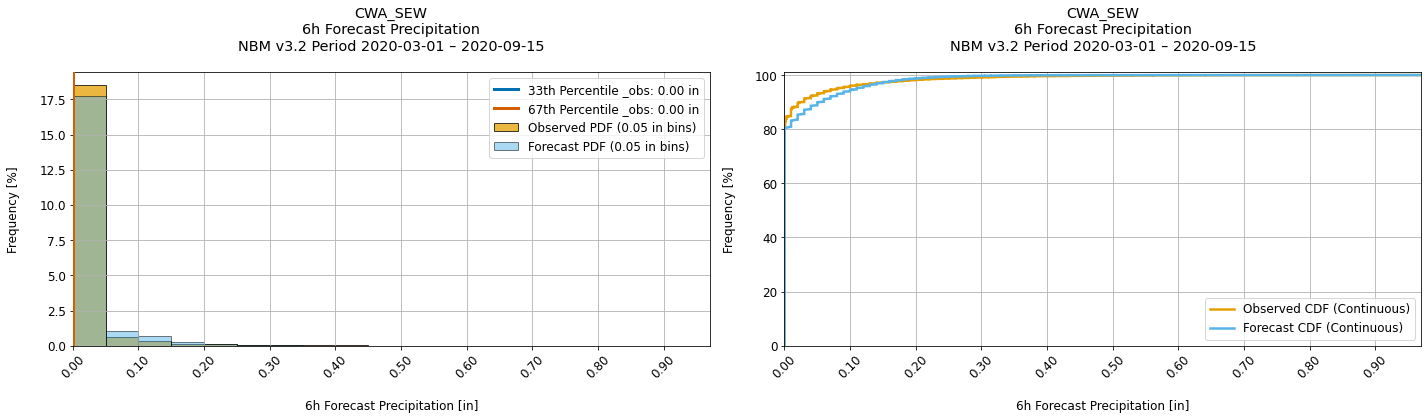

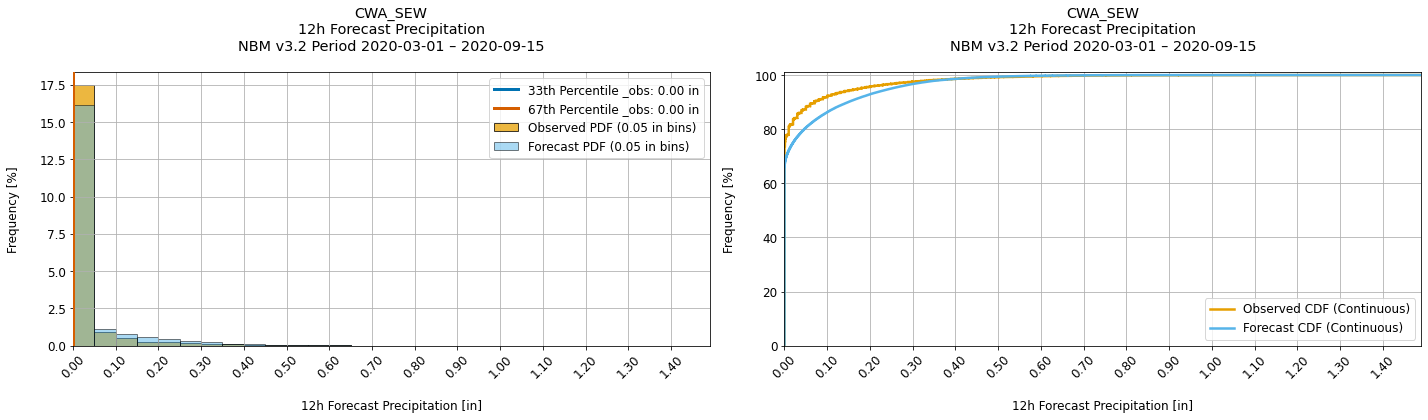

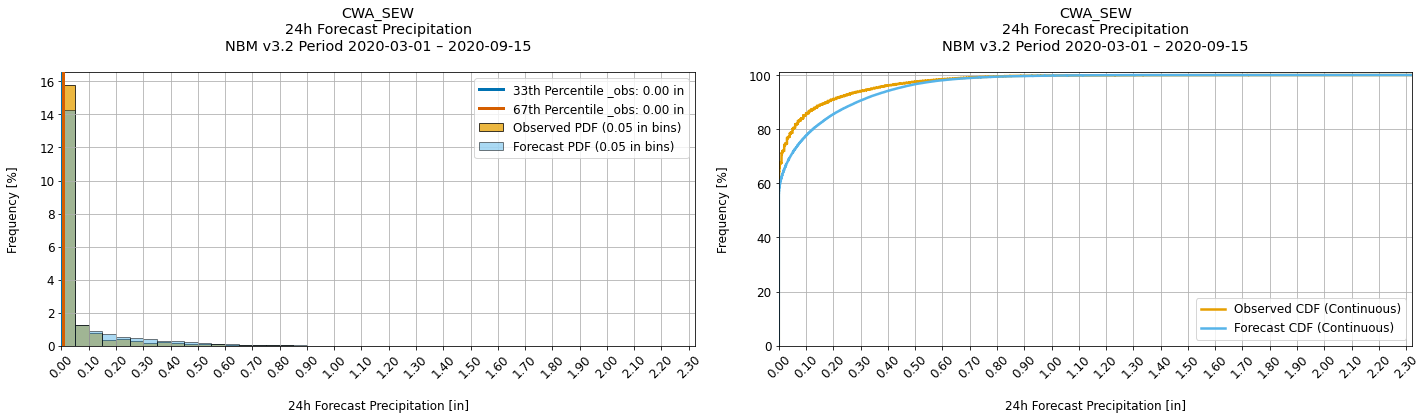

{6: array([0.  , 0.  , 0.  , 1.02]),
 12: array([0.  , 0.  , 0.  , 1.54]),
 24: array([0.        , 0.        , 0.00393701, 2.37204724])}

In [15]:
thresh_id = nbm_funcs._thresh_id = {'Small':[0, 1], 'Medium':[1, 2], 'Large':[2, 3], 'All':[0, 3]}

# 33rd, 67th percentile determined above
thresholds = nbm_funcs._thresholds = {interval:nbm_funcs.apcp_dist_plot(obs, nbm, interval, trimZero=False, show=True) 
              for interval in [6, 12, 24]}

thresholds

In [16]:
# Force Override
nbm_funcs._thresholds = thresholds = {
    6:  np.array([0., 0.10, 0.25, np.inf]),
    12: np.array([0., 0.10, 0.5, np.inf]),
    24: np.array([0., 0.5, 2.0, np.inf]),}

***
***
# Reorganize the data for analysis:
#### Isolate the forecasts by accumulation interval and lead time

In [18]:
plist = np.arange(1, 100)

# matchfile = datadir + 'matched/CWA_%s_%s_%s_verifMatched.NPremoved.pd'%(
matchfile = datadir + 'matched/CWA_%s_%s_%s_verifMatched.pd'%(
    cwa, date0.strftime('%Y%m%d'), date1.strftime('%Y%m%d'))

if os.path.isfile(matchfile):
    data = pd.read_pickle(matchfile)

else:
    
    os.makedirs('/'.join(matchfile.split('/')[:-1]), exist_ok=True)
    
    data = []
    for interval in [24]:

        pkeys = np.array([k for k in nbm.keys() if '%dhr_'%interval in k])
        pkeys = np.array([k for k in pkeys if '%' in k])
        pkeys = pkeys[np.argsort([int(k.split('_')[-1].split('%')[0]) for k in pkeys])]

        for lead_time in np.arange(interval, lead_time_end, 6):

            for esize in ['Small', 'Medium', 'Large', 'NP']:

                try:
                    thresh = [thresholds[interval][thresh_id[esize][0]], 
                              thresholds[interval][thresh_id[esize][1]]]
                except:
                    thresh = [0, 0]

                print('\rProcessing interval %d lead %dh'%(interval, lead_time), end='')

                # We need to break out the verification to each lead time,
                # but within each lead time we have a number of valid times.
                # At each lead time, valid time, isolate the forecast verification

                # Combine the datasets to make it easier to work with
                idata = nbm[nbm['LeadTime'] == lead_time].merge(obs, on=['ValidTime', 'Site']).drop(columns='LeadTime')

                # Subset for event size using the observed precip
                iobs = idata['%dh_precip_in'%interval]
                #iobs = iobs.replace(np.nan, 0.) if 'NPremoved' in matchfile else iobs

                # Do the trimming of the selected dataset
                if esize != 'NP':
                    idata = idata[((iobs >= thresh[0]) & (iobs < thresh[1]))]
                else:
                    idata = idata[iobs == 0]

                del iobs

                idata['%dh_precip_in'%interval] = (idata['%dh_precip_in'%interval]#.replace(np.nan, 0) 
                    if 'NPremoved' in matchfile else idata['%dh_precip_in'%interval])

                for itime in idata.index:

                    try:
                        prob_fx = idata.loc[itime, pkeys]
                        mean_fx = np.nanmean(prob_fx)
                        std_fx = np.nanstd(prob_fx)
                        med_fx = idata.loc[itime, 'APCP%dhr_surface_50%% level'%interval]
                        det_fx = idata.loc[itime, 'APCP%dhr_surface'%interval]
                        
                        pop_fx = idata.loc[itime, 'APCP%dhr_surface_prob >0.254'%interval]
                                                
                        # Optional - leave as nan?
                        det_fx = det_fx if ~np.isnan(det_fx) else 0.

                        verif_ob = idata.loc[itime, '%dh_precip_in'%interval]

                        verif_rank = np.searchsorted(prob_fx, verif_ob, 'right')                    
                        verif_rank_val = prob_fx[verif_rank-1]
                        verif_rank_error = verif_rank_val - verif_ob

                        verif_rank = 101 if ((verif_rank >= 99) & (verif_ob > verif_rank_val)) else verif_rank
                        verif_rank = -1 if ((verif_rank <= 1) & (verif_ob < verif_rank_val)) else verif_rank

                        det_rank = np.searchsorted(prob_fx, det_fx, 'right')
                        det_error = det_fx - verif_ob

                    except:
                        pass
                        # print('failed', itime)

                    else:
                        if ~np.isnan(verif_rank_val):

                            data.append([
                                # Indexers
                                interval, lead_time, itime[0], itime[1], esize,

                                # Verification and deterministic
                                verif_ob, det_fx, det_rank, det_error,

                                # Probabilistic
                                verif_rank, verif_rank_val, verif_rank_error, 
                                med_fx, mean_fx, std_fx, pop_fx])

    data = pd.DataFrame(data, columns=['Interval', 'LeadTime', 'ValidTime', 'Site', 'EventSize',
                    'verif_ob', 'det_fx', 'det_rank', 'det_error',
                    'verif_rank', 'verif_rank_val', 'verif_rank_error', 
                    'med_fx', 'mean_fx', 'std_fx', 'pop'])

    data.to_pickle(matchfile)
    
print('\n\nAvailable keys:\n\t\t{}\nn rows: {}\n'.format('\n\t\t'.join(data.keys()), len(data)))

data

Processing interval 24 lead 174h

Available keys:
		Interval
		LeadTime
		ValidTime
		Site
		EventSize
		verif_ob
		det_fx
		det_rank
		det_error
		verif_rank
		verif_rank_val
		verif_rank_error
		med_fx
		mean_fx
		std_fx
		pop
n rows: 114673



,Interval,LeadTime,ValidTime,Site,EventSize,verif_ob,det_fx,det_rank,det_error,verif_rank,verif_rank_val,verif_rank_error,med_fx,mean_fx,std_fx,pop
0,24,24,2020-03-03 12:00:00,K0S9,Small,0.03,0.150866,43,0.120866,18,0.028937,-0.001063,0.196339,0.261176,0.250336,85.0
1,24,24,2020-03-03 12:00:00,KBFI,Small,0.00,0.158701,48,0.158701,8,0.000000,0.000000,0.166378,0.226665,0.220390,82.0
2,24,24,2020-03-03 12:00:00,KBVS,Small,0.24,0.369803,75,0.129803,49,0.239213,-0.000787,0.243346,0.268405,0.186205,97.0
3,24,24,2020-03-03 12:00:00,KCLM,Small,0.03,0.116969,43,0.086969,20,0.029646,-0.000354,0.147913,0.181819,0.163866,81.0
4,24,24,2020-03-03 12:00:00,KCLS,Small,0.03,0.134094,47,0.104094,10,0.028937,-0.001063,0.140669,0.149055,0.092829,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114668,24,168,2020-09-22 12:00:00,KCLS,NP,0.00,0.000000,75,0.000000,75,0.000000,0.000000,0.000000,0.022796,0.070598,19.0
114669,24,168,2020-09-22 12:00:00,KNOW,NP,0.00,0.000000,67,0.000000,67,0.000000,0.000000,0.000000,0.013916,0.045897,14.0
114670,24,168,2020-09-22 12:00:00,KOLM,NP,0.00,0.000000,75,0.000000,75,0.000000,0.000000,0.000000,0.023290,0.069188,18.0
114671,24,168,2020-09-22 12:00:00,KPWT,NP,0.00,0.000000,72,0.000000,72,0.000000,0.000000,0.000000,0.037318,0.100732,23.0


In [19]:
print(cwa)
data[data['EventSize'] == 'Large'].describe().T

SEW


,count,mean,std,min,25%,50%,75%,max
Interval,3.0,24.000000,0.000000,24.000000,24.000000,24.000000,24.000000,24.000000
LeadTime,3.0,54.000000,24.000000,30.000000,42.000000,54.000000,66.000000,78.000000
verif_ob,3.0,2.372047,0.000000,2.372047,2.372047,2.372047,2.372047,2.372047
det_fx,3.0,1.172874,0.141550,1.010315,1.124862,1.239409,1.254154,1.268898
det_rank,3.0,73.333333,1.527525,72.000000,72.500000,73.000000,74.000000,75.000000
det_error,3.0,-1.199173,0.141550,-1.361732,-1.247185,-1.132638,-1.117894,-1.103150
verif_rank,3.0,100.000000,1.732051,98.000000,99.500000,101.000000,101.000000,101.000000
verif_rank_val,3.0,2.312388,0.060452,2.244449,2.288465,2.332480,2.346358,2.360236
verif_rank_error,3.0,-0.059659,0.060452,-0.127598,-0.083583,-0.039567,-0.025689,-0.011811
med_fx,3.0,0.878963,0.101683,0.763465,0.840945,0.918425,0.936713,0.955000


NPEs


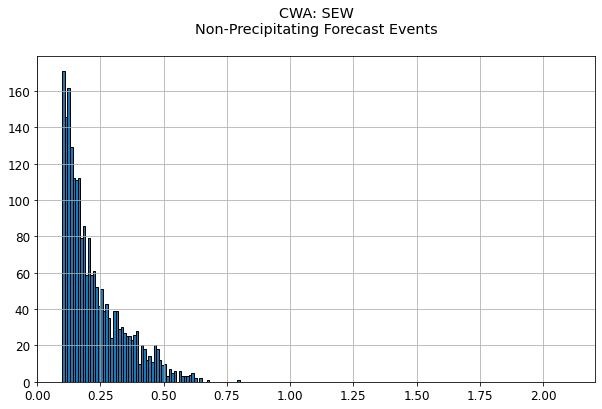

,count,mean,std,min,25%,50%,75%,max
det_fx,6222.0,0.105475,0.111636,0.010039,0.028819,0.062933,0.138848,0.797677


In [20]:
print('NPEs')

fig = plt.figure(facecolor='w', figsize=(10, 6))

plt.hist(data[(data['EventSize'] == 'NP')&(data['det_fx'] > 0.1)]['det_fx'], bins=np.arange(0.01, 2.1, .01), edgecolor='k')

# plt.ylim(top=800)
plt.xlim(left=0)
plt.grid()
plt.title('CWA: %s\nNon-Precipitating Forecast Events\n%s'%(cwa, ''))

plt.show()

data[((data['EventSize'] == 'NP') & (data['det_fx'] > 0.01))][['det_fx']].describe().T

***
***
# Create Bulk Temporal Stats Plots
#### Reliability diagrams, bias over time, rank over time, etc.

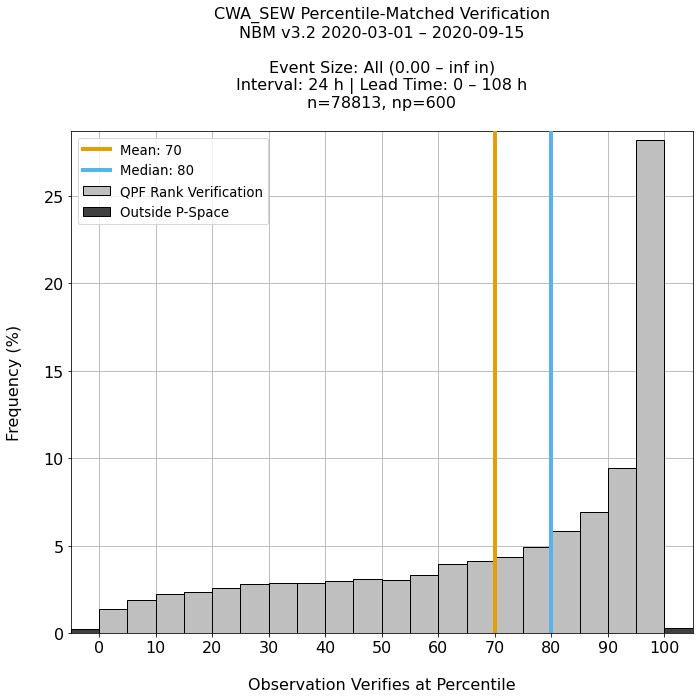

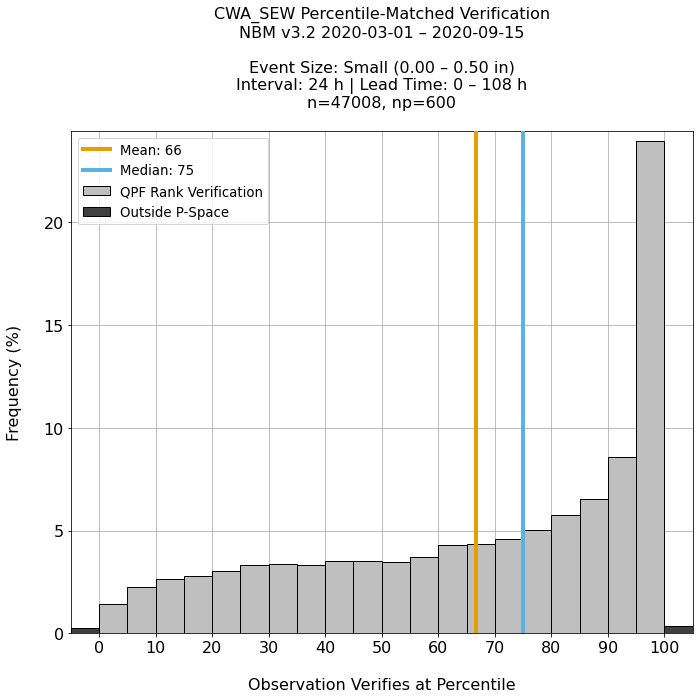

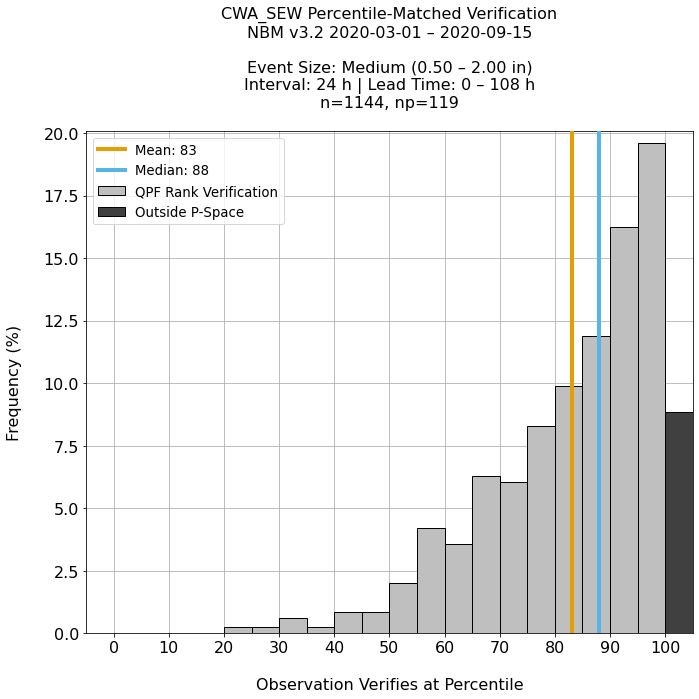

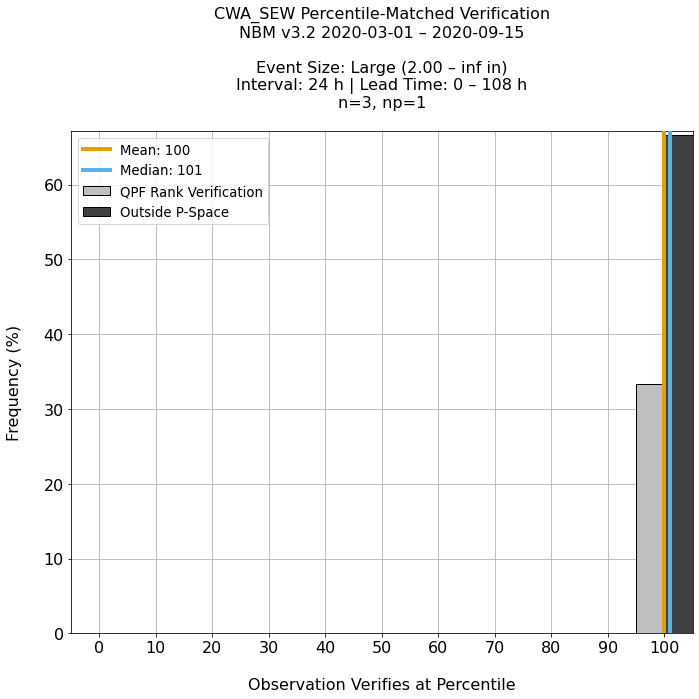

In [21]:
plot_type = 'Verification'
plot_var = 'verif_rank'

for esize in ['All', 'Small', 'Medium', 'Large']:
    for interval in [24]: #[6, 12, 24]:
        for short, long in zip([0], [108]): #zip([0, 48, 108], [48, 108, 180]):

            kwargs = {'_interval':interval, '_esize':esize,
                     '_short':short, '_long':long,
                     '_plot_type':plot_type, '_plot_var':plot_var}
            
            try:
                nbm_funcs.histograms_verif_rank(data, **kwargs, show=True)
            except:
                pass

#### Plot a reliability diagram style CDF to evaluate percentile rankings

In [22]:
short, long = 0, 120
plot_type = 'Verification'
plot_var = 'verif_rank'
esize = 'All'

for esize in ['All', 'Small', 'Medium', 'Large']:
    for interval in [24]: #[6, 12, 24]:
        for short, long in zip([0], [108]): #zip([0, 48, 108], [48, 108, 180]):
        
                kwargs = {'_interval':interval, '_esize':esize,
                         '_short':short, '_long':long,
                         '_plot_type':plot_type, '_plot_var':plot_var}

                #nbm_funcs.reliability_verif_cdf_multistation(data, **kwargs, show=True)

#### Produce bias, ME, MAE, and percentile rank plots as they evolve over time
This helps illustrate at what leads a dry/wet bias may exist and how severe it may be<br>
Adds value in interpreting the CDF reliability diagrams

In [23]:
# short, long = 0, 120
# esize = 'All'

# for interval in [6, 12, 24]:

#     kwargs = {'_interval':interval, '_esize':esize,
#              '_short':short, '_long':long}

#     nbm_funcs.rank_over_leadtime(data, **kwargs, show=True)

## Create PODs/traditional metrics

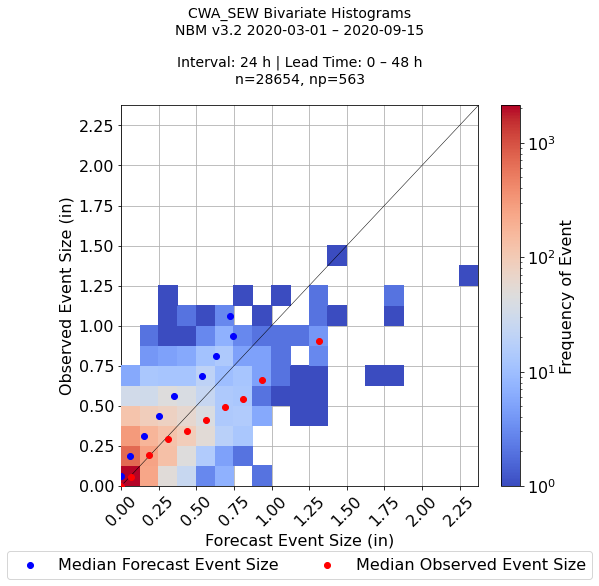

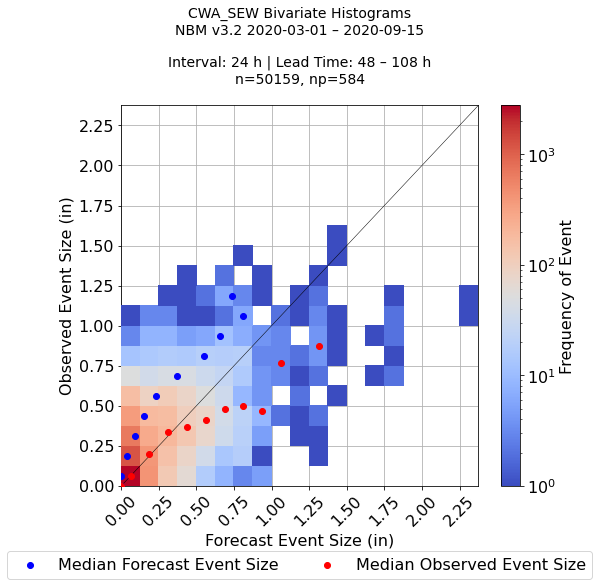

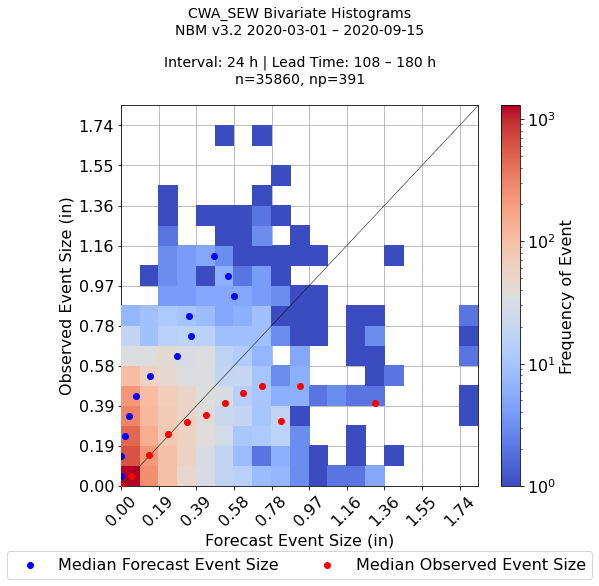

In [25]:
esize = 'All'

verif_on = 'det_fx' #det_fx

for interval in [24]:
    for short, long in zip([0, 48, 108], [48, 108, 180]):

        select = data[((data['Interval'] == interval)
                        & ((data['LeadTime'] > short) 
                        & (data['LeadTime'] <= long)))]

        select = select[select['EventSize'] == esize] if esize != 'All' else select

#         select = select[(select['verif_ob'] > 0.05) & (select['det_fx'] > 0.05)]
        
        maxval = max(max(select['verif_ob']), max(select[verif_on]))
        bins = np.linspace(0.001, maxval, 20)


        scatter2d = []
        for i, v in enumerate(bins):
            v0 = bins[i-1] if i > 0 else 0

            vf = select[(select[verif_on] > v0) & (select[verif_on] <= v)]['verif_ob']
            vf = vf.median() if vf.size >= 10 else np.nan

            vo = select[(select['verif_ob'] > v0) & (select['verif_ob'] <= v)][verif_on]
            vo = vo.median() if vo.size >= 10 else np.nan

            scatter2d.append((np.nanmean([v0, v]), vf, vo))
        scatter2d = np.array(scatter2d)


        fig, ax = plt.subplots(1, figsize=(8, 7), facecolor='w')

        cbd = ax.hist2d(select['verif_ob'], select[verif_on], density=False, bins=[bins, bins], cmap='coolwarm', norm=matplotlib.colors.LogNorm(), zorder=10)
        ax.plot(np.arange(0, maxval*2), 'k-', linewidth=0.5, zorder=11)

        ax.set_xticks(bins[::2])
        ax.set_xticklabels(['%.2f'%b for b in bins[::2]], rotation=45)

        ax.set_yticks(bins[::2])
        ax.set_yticklabels(['%.2f'%b for b in bins[::2]], rotation=0)

        ax.grid(zorder=-1)

        vxy = scatter2d[:, 0]
        vf = scatter2d[:, 1]
        vo = scatter2d[:, 2]

        ax.scatter(vf, vxy, zorder=20, c='b', label='Median Forecast Event Size')
        ax.scatter(vxy, vo, zorder=20, c='r', label='Median Observed Event Size')

        ax.set_xlabel('Forecast Event Size (in)')
        ax.set_ylabel('Observed Event Size (in)')

        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

        plt.colorbar(cbd[3], ax=ax, label='Frequency of Event')

        n_precip_periods = np.unique(select['ValidTime'][~np.isnan(select['verif_ob'])]).shape[0]

        ax.set_title(('{} Bivariate Histograms\nNBM v3.2 {} – {}\n\n' + 
                      'Interval: {} h | Lead Time: {} – {} h\nn={}, np={}\n').format(
                    site, date0.strftime('%Y-%m-%d'), date1.strftime('%Y-%m-%d'),
                    interval, short, long, len(select), n_precip_periods), size=14)

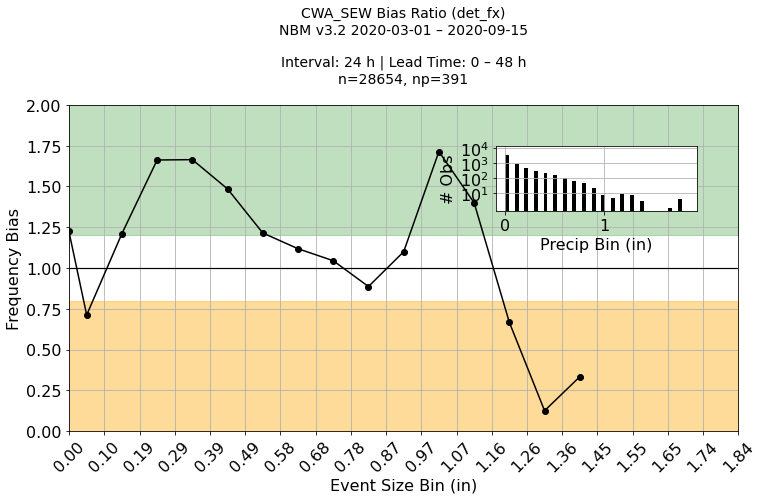

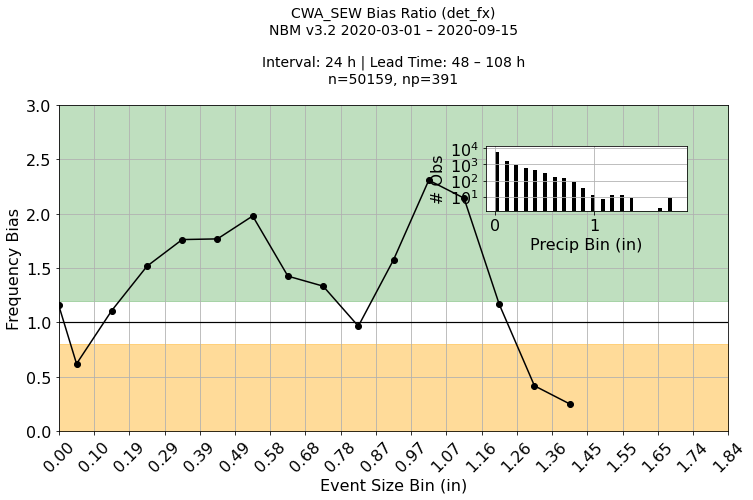

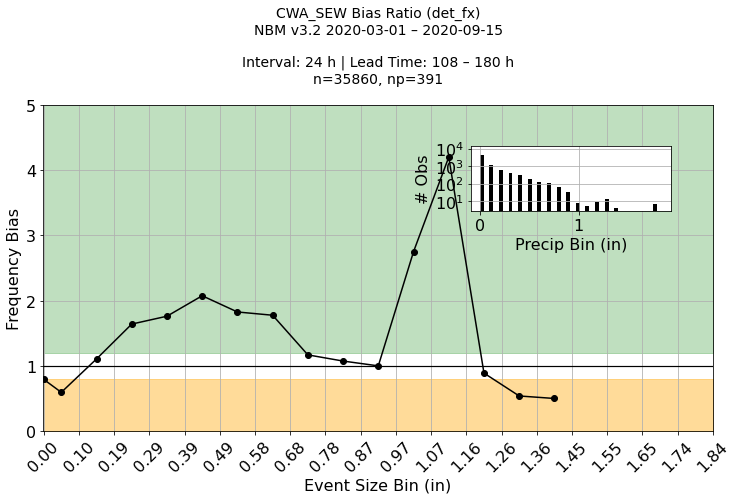

In [27]:
verif_on = 'det_fx'

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for interval in [24]:
    for short, long in zip([0, 48, 108], [48, 108, 180]):

        esize = 'All'

        select = data[((data['Interval'] == interval)
                        & ((data['LeadTime'] > short) 
                        & (data['LeadTime'] <= long)))]

        select = select[select['EventSize'] == esize] if esize != 'All' else select

        # select = select[(select['verif_ob'] > 0) & (select['det_fx'] > 0)]

        bins = np.linspace(0.001, maxval, 20)

        bias_ratio = []
        for i, v in enumerate(bins):

            v0 = bins[i-1] if i > 0 else 0
            vf = select[(select[verif_on] > v0) & (select[verif_on] <= v)]['verif_ob']
            vf = vf[vf > 0]
            vo = select[(select['verif_ob'] > v0) & (select['verif_ob'] <= v)][verif_on]
            vo = vo[vo > 0]

            try:
                br = vf.size/vo.size
            except:
                pass
            else:
                br = np.nan if br == 0 else br
                bias_ratio.append((np.nanmean([v0, v]), br))

        bias_ratio = np.array(bias_ratio)

        fig, ax = plt.subplots(1, figsize=(12, 6), facecolor='w')

        ax.plot(bias_ratio[:, 0], bias_ratio[:, 1], 'k-o')
        ax.axhline(1, c='k', linewidth=1.2)

        yx = np.nanmax(bias_ratio[:, 1])
        yx = np.ceil(yx * 1.1)

        yn = np.nanmin(bias_ratio[:, 1])
        yn = np.floor(yn * 0.9)

        ax.fill_between(bins, 1.2, yx, color='green', alpha=0.25)
        ax.fill_between(bins, yn, 0.8, color='orange', alpha=0.4)

        ax.set_xticks(bins)
        ax.set_xticklabels(['%.2f'%b for b in bins], rotation=45)

        # ax.set_yticks(np.arange(yn, yx, .2))

        ax.set_xlim([0, bins[-1]])
        ax.set_ylim([yn, yx])

        ax.set_xlabel('Event Size Bin (in)')
        ax.set_ylabel('Frequency Bias')

        axi = inset_axes(ax, width="200%", height="200%",
                           bbox_to_anchor=(.8, .8, .15, .1),
                           bbox_transform=ax.transAxes, loc=1)

        axi.hist(select['verif_ob'][select['verif_ob'] > 0], bins=bins, color='k', width=0.04)

        ax.set_xlim(right=bins[-1])
        axi.set_yscale('log')
        axi.set_ylim(top=15e3)
        axi.set_yticks([1e1, 1e2, 1e3, 1e4])

        axi.set_xlabel('Precip Bin (in)')
        axi.set_ylabel('# Obs')
        axi.grid(True)
        
        ax.set_title(('{} Bias Ratio ({})\nNBM v3.2 {} – {}\n\n' + 
              'Interval: {} h | Lead Time: {} – {} h\nn={}, np={}\n').format(
            site, verif_on, date0.strftime('%Y-%m-%d'), date1.strftime('%Y-%m-%d'),
            interval, short, long, len(select), n_precip_periods), size=14)

        ax.grid()

N: 13593


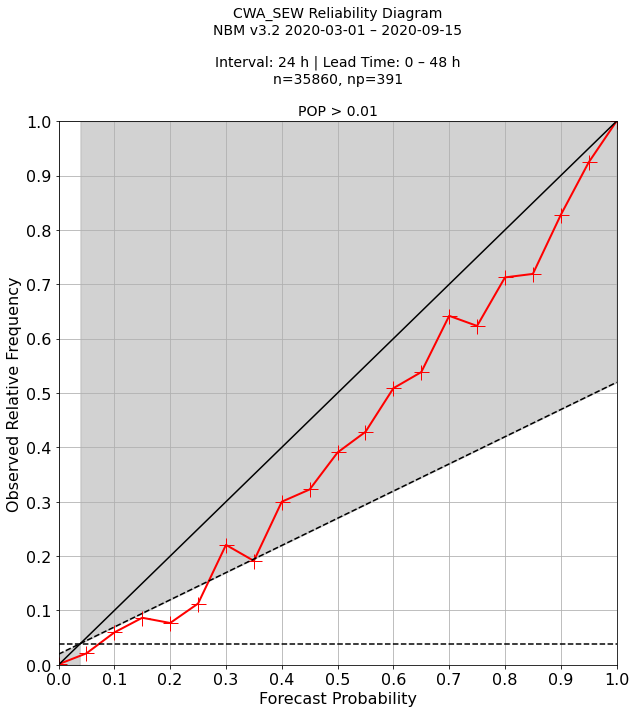

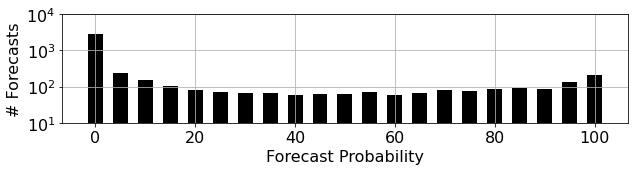

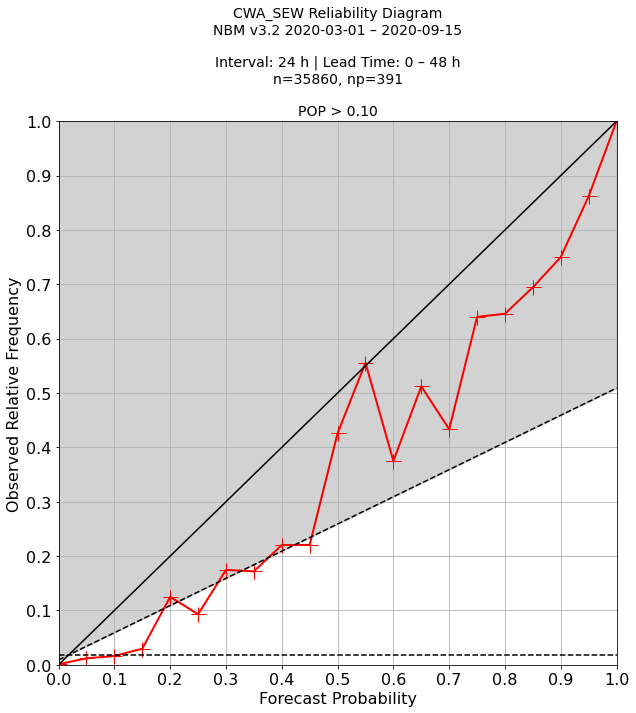

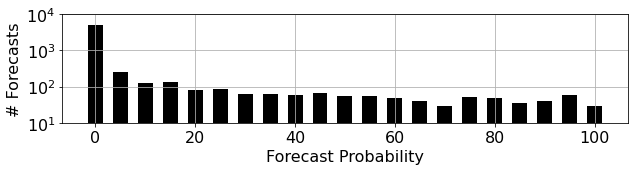

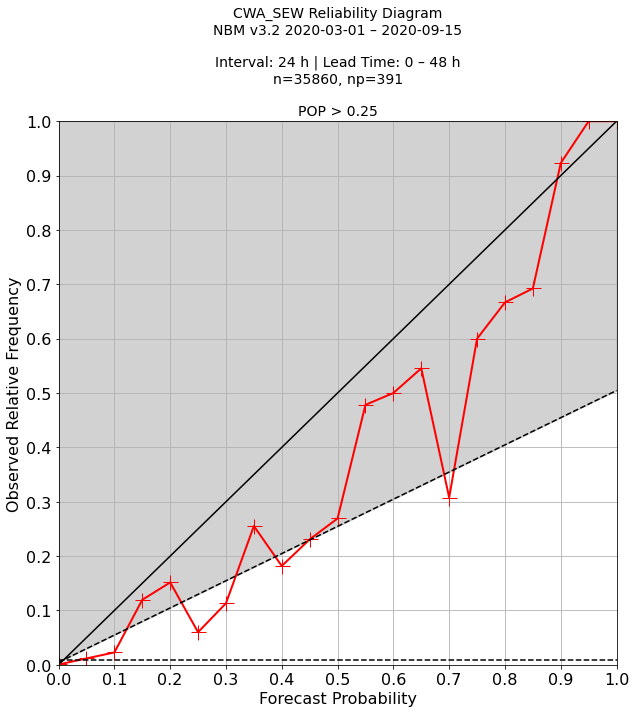

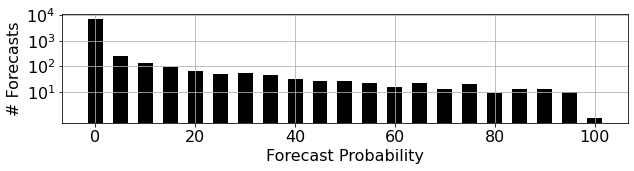

In [28]:
probkeys = ['APCP6hr_surface_prob >0.254', 'APCP12hr_surface_prob >0.254', 
    'APCP24hr_surface_prob >0.254', 'APCP24hr_surface_prob >2.54',
    'APCP24hr_surface_prob >6.35', 'APCP24hr_surface_prob >12.7',
    'APCP24hr_surface_prob >25.4', 'APCP24hr_surface_prob >50.8',
    'APCP24hr_surface_prob >76.2', 'APCP24hr_surface_prob >101.6',
    'APCP24hr_surface_prob >127', 'APCP24hr_surface_prob >152.4']

probkeys_in = [k.replace(k.split('>')[1], str(np.ceil(float(k.split('>')[1])*100*mm_in)/100)) for k in probkeys]
probkeys.append('LeadTime')

for short, long in zip([0], [48]):
    for interval in [24]:
        
        prob = nbm.loc[:, probkeys].rename(columns={k:nk for k, nk in zip(probkeys, probkeys_in)}
                                              ).reset_index().set_index(['ValidTime', 'Site']).drop(columns='InitTime')

        prob = prob[(prob['LeadTime'] > short) & (prob['LeadTime'] <= long)]

        prob = obs[['%dh_precip_in'%interval]].join(prob, on=['ValidTime', 'Site'])
        prob[prob.duplicated(keep='first')]

        prob['%dh_precip_in'%interval] = prob['%dh_precip_in'%interval]#.replace(np.nan, 0)
        prob = prob[~np.isnan(prob['%dh_precip_in'%interval])].dropna(how='any')

        N = prob.shape[0]
        print('N:', N)

        for reli_thresh in [0.01, 0.1, 0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]:
        
            try:

                bins = np.arange(0, 101, 5)

                K = len(bins)
                o_bar = prob[prob['%dh_precip_in'%interval] > reli_thresh].size/N

                reliplot = []
                fcast_hist = []
                for i, p in enumerate(bins):
                    p0, p1 = p-0.025, p+0.025

                    pi = prob[(prob['APCP%dhr_surface_prob >%s'%(interval, reli_thresh)] > p0) & 
                                  (prob['APCP%dhr_surface_prob >%s'%(interval, reli_thresh)] <= p1)]

                    nk = pi.shape[0]
                    fcast_hist.append([p, nk])
                    
                    ok_bar = (pi[pi['%dh_precip_in'%interval] > reli_thresh].shape[0]/nk) * 100

                    reliplot.append([p/100, ok_bar/100])

                reliplot = np.array(reliplot)
                fcast_hist = np.array(fcast_hist)
                
                fig, ax = plt.subplots(figsize=(10, 10), facecolor='w')

                fcast_prob = reliplot[:, 0]
                obs_freq = reliplot[:, 1]

                perf = np.arange(0, 1.1, .1)
                climo = o_bar/100
                skill = perf - ((perf - climo)/2)

                ax.plot(fcast_prob, obs_freq, 
                        color='r', linewidth=2,
                        marker='+', markersize=15)

                ax.plot(perf, perf, 
                        color='k')

                ax.axhline(climo, 
                        color='k', linestyle='--')

                ax.plot(perf, skill, 
                        color='k', linestyle='--')

                try:
                    focal = np.arange(0, 1, 0.0001)[np.where(
                        np.arange(0, 1, 0.0001) == round(climo, 3))][0]

                    fillperf = np.arange(focal, 1, .001)
                    ax.fill_between(fillperf, fillperf - (fillperf - climo)/2, 1,
                            color='gray', alpha=0.35)

                    fillperf = np.arange(0, focal, .001)
                    ax.fill_between(fillperf, 0, fillperf - (fillperf - climo)/2,
                            color='gray', alpha=0.35)
                except:
                    fillperf = np.arange(0, 1, .001)
                    ax.fill_between(fillperf, fillperf - (fillperf - climo)/2, 1,
                            color='gray', alpha=0.35)

                ax.set_xlim([0, 1])
                ax.set_ylim([0, 1])

                ax.set_xticks(perf)
                ax.set_yticks(perf)
                
                ax.set_xlabel('Forecast Probability')
                ax.set_ylabel('Observed Relative Frequency')

                ax.grid(zorder=1)

                ax.set_title(('{} Reliability Diagram\nNBM v3.2 {} – {}\n\n' + 
                              'Interval: {} h | Lead Time: {} – {} h\nn={}, np={}\n\n' + 
                              'POP > {:.2f}').format(
                            site, date0.strftime('%Y-%m-%d'), date1.strftime('%Y-%m-%d'),
                            interval, short, long, len(select), n_precip_periods, reli_thresh), size=14)

                plt.show()
                
                fig, ax = plt.subplots(figsize=(10.135, 2), facecolor='w')
                ax.bar(fcast_hist[:, 0], fcast_hist[:, 1], color='k', width=3)
                
                ax.set_yscale('log')
                ax.set_yticks([1e1, 1e2, 1e3, 1e4])
                
                ax.set_xlabel('Forecast Probability')
                ax.set_ylabel('# Forecasts')
                
                ax.grid()
                plt.show()
                
                print('\n\n')

            except:
                pass